# PROJECT 2 - INTEGER PROGRAMMING

### Group 25 Members

1. SANTHOSH RAMKUMAR (SR55965)
2. BHUVANA CHANDRIKA KOTHAPALLI (BK24542)
3. GAYTRI RIYA VASAL (GRV377)
4. JAHNAVI ANGATI (JA54632)


### Set the Time constraint below

In [1]:
T = 3600

### Modules

In [2]:
import pandas as pd
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt
import seaborn as sns
# set the max columns to none
pd.set_option('display.max_columns', None)
# set the max rows to none
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore")

C:\Users\rsk29\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### Load the Data

In [3]:
stocks_2019 = pd.read_csv(r'stocks2019.csv')
stocks_2020 = pd.read_csv(r'stocks2020.csv')

In [4]:
#Number of day in 2019 for which the stock market was active
days_2019 = stocks_2019.shape[0]
print('Number of days stock market was active in 2019 = ', days_2019)

#Number of stocks in the 2019 dataset (First two columns removed as they are the 'Date' and 'Index')
n = stocks_2019.shape[1]-2
print('Number of stocks in 2019 dataset = ', n)

Number of days stock market was active in 2019 =  251
Number of stocks in 2019 dataset =  100


#### Why should we consider investing?

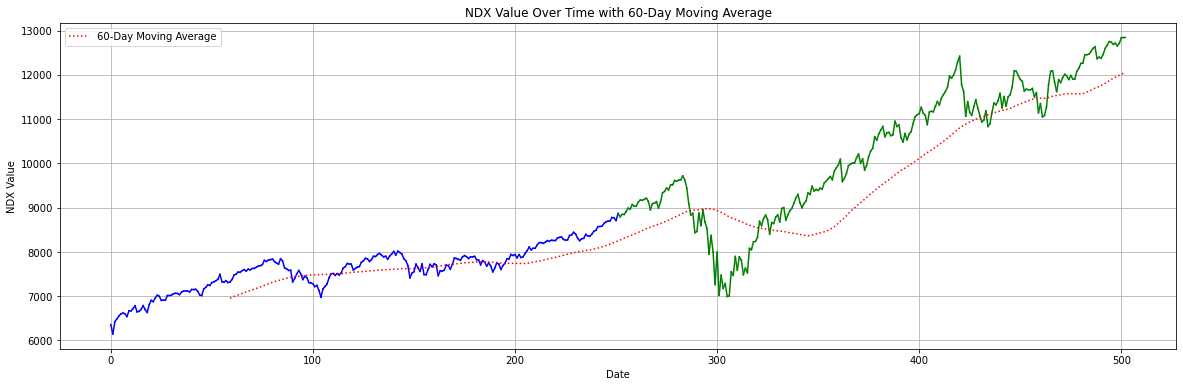

In [5]:
# Combine the 'NDX' columns into a single list
ndxs_combined = list(stocks_2019['NDX']) + list(stocks_2020['NDX'])

# Calculate the 60-day moving average
rolling_average = pd.Series(ndxs_combined).rolling(window=60).mean()

# Create a line chart with different colors for 2019 and 2020 NDX data
plt.figure(figsize=(20, 6))
colors = ['blue'] * len(stocks_2019) + ['green'] * len(stocks_2020)

for i in range(len(ndxs_combined) - 1):
    plt.plot([i, i + 1], [ndxs_combined[i], ndxs_combined[i + 1]], color=colors[i])

# Plot the moving average as a red dotted line with a label
plt.plot(rolling_average, label='60-Day Moving Average', color='red', linestyle='dotted')

plt.xlabel('Date')
plt.ylabel('NDX Value')
plt.title('NDX Value Over Time with 60-Day Moving Average')
plt.legend()
plt.grid(True)
plt.show()

The growing trend of the index from 2019 to 2020 shows that there is value in investing!

### Q1 - Getting the returns matrix and calculating the correlation

#### Objective Function
$$\underset{x,y}{max}\sum_{i=1}^{n}\sum_{j=1}^{n}\rho _{ij}x_{ij}$$

#### Constraint 1 - Limiting the number of selected stocks to m
$$\sum_{j=1}^{n} y_{j} = m$$

#### Constraint 2 - Limiting the similar stock count to 1
$$\sum_{j=1}^{n} x_{ij} = 1 \: for\: i = 1,2,....n$$

#### Constraint 3 - Making sure best stock representation is in fund
$$x_{ij} \leq y_{ij} \:for\: i,j = 1,2....n$$

In [6]:
returns_2019 = stocks_2019.copy()  # Create a copy of the original DataFrame
returns_2019.drop(columns=['X'], inplace=True)  # Drop the 'Date' column
# Calculate daily returns
returns_2019 = returns_2019.pct_change().fillna(0)
#Now, lets calculate the correlation matrix --> This will give us the correlation of the 'RETURNS' from each stock with repect to each other
correl_2019 = returns_2019.drop(columns=['NDX']).corr()

### Q2 - Stock Selection

Now that we have the correlation matrix for the returns we can build an optimization problem to pick m stocks that maximizes the correlation between the selected stock and representative from the NASDAQ index.

In [7]:
m = 5

fund_creator = gp.Model() 
selected_stocks = fund_creator.addMVar(n, vtype = 'B') #Binary variable to flag the selected stocks
linking_stocks = fund_creator.addMVar((n,n), vtype = 'B') #Binary variable to link stock in index to the fund

selection_const = fund_creator.addConstr(gp.quicksum(selected_stocks[i] for i in range(n)) <= m)
one_representative_const = fund_creator.addConstrs(gp.quicksum(linking_stocks[i,j] for j in range(n)) ==1 for i in range(n))
ensure_best_representative_const = fund_creator.addConstrs(linking_stocks[i,j] <= selected_stocks[j] for j in range(n) for i in range(n))

# Set the objective function using the calculated values
fund_creator.setObjective(gp.quicksum(correl_2019.iloc[i, j] * linking_stocks[i,j] for i in range(n) for j in range(n) ), sense=gp.GRB.MAXIMIZE)
fund_creator.Params.OutputFlag = 0
fund_creator.optimize()

# Convert the array to a pandas Series for easier manipulation
selection_series = pd.Series(selected_stocks.x)

# Get the selected columns from returns_2019
selected_columns = correl_2019.columns[selection_series == 1]
selected_columns_list = selected_columns.tolist()
# Print the names of the selected columns
selected_columns_list

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2404422
Academic license - for non-commercial use only - registered to mayday99@utexas.edu


['LBTYK', 'MXIM', 'MSFT', 'VRTX', 'XEL']

#### Now lets see how these 5 stocks rank in terms of being correlated with other stocks in the dataset

The way we have optimized the model will map each stock in the NASDAQ index to one stock in the fund we create. So lets understand the importance of the stocks in the fund based on how many index stocks are mapped to them (representations). 

,stock,representations_from_index
0,MSFT,53.0
1,MXIM,30.0
2,VRTX,10.0
3,XEL,4.0
4,LBTYK,3.0


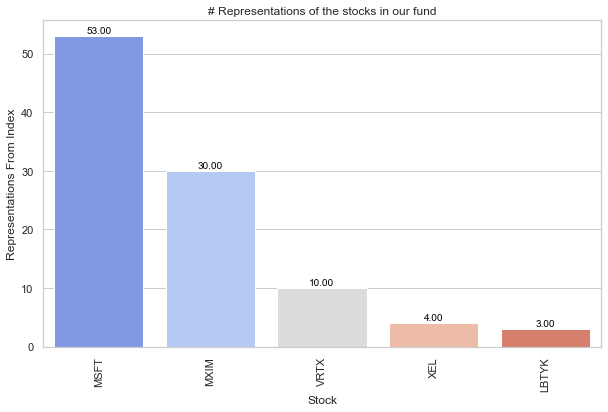

In [8]:
#Now lets see how these 5 stocks rank in terms of being correlated with other stocks in the dataset
linking_stocks_df = pd.DataFrame(linking_stocks.x.tolist())
linking_stocks_df.columns = correl_2019.columns
linkings_graph = linking_stocks_df.sum().sort_values(ascending = False).head(m)
linkings_graph = pd.DataFrame(linkings_graph).reset_index()
linkings_graph.columns = ['stock','representations_from_index']
display(linkings_graph)

# Set the style of the plot using Seaborn
sns.set(style="whitegrid")

# Create a bar plot with the "coolwarm" palette
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='stock', y='representations_from_index', data=linkings_graph, palette="coolwarm")

# Customize the plot
plt.xlabel('Stock')
plt.ylabel('Representations From Index')
plt.title('# Representations of the stocks in our fund')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability

# Add values on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

# Show the plot
plt.show()

From the above chart we see that MSFT (Microsoft) is the most representative stock out the top 5 we have selected! Now let's try to see how its return trends with the index returns to make more sense out of the optimization.

In [9]:
#Now let's create a dataframe that only has the selected stocks from the above optimzation output

selected_stocks = returns_2019[selected_columns_list]
index_2019 = returns_2019['NDX']


In [10]:

# # Calculate the 60-day moving average for the NASDAQ Index
# moving_avg_index_2019 = index_2019.rolling(window=60).mean()

# # Calculate the 60-day moving average for MSFT
# moving_avg_MSFT = selected_stocks['MSFT'].rolling(window=60).mean()

# # Calculate the 60-day moving average for MXIM
# moving_avg_MXIM = selected_stocks['MXIM'].rolling(window=60).mean()

# # Create the main figure with one subplot
# fig, ax = plt.subplots(figsize=(20, 8))

# # Plot the 60-day moving averages for NASDAQ Index, MSFT, and MXIM
# ax.plot(moving_avg_index_2019, label='NASDAQ Index 60-Day MA', linestyle='-')
# ax.plot(moving_avg_MSFT, label='MSFT 60-Day MA', linestyle='--')
# ax.plot(moving_avg_MXIM, label='MXIM 60-Day MA', linestyle='--')

# # Title and legend for the subplot
# ax.set_title('Comparing the 60-Day Moving Averages of NASDAQ Index, MSFT, and MXIM')
# ax.legend()

# # Add a grid
# ax.grid(False)

# # Show the plot
# plt.show()


MSFT tracks the index decently. Its increase / decrease is correlated with the index but the magnitude of the return are quite different and it can be seen clearly from the chart. MXIM tracks the NASDAQ index on and off. Similar to MSFT, its magnitude of returns is quite different from the index. The remaining 3 stocks in the fund, though not as highly representative as these two, will track the index to an extent. 

**These finidings builds confidence in the approach that we have taken to select the stocks for our fund based on correlation**



### Q2 - Portfolio Weights calculation

#### Objective Function
$$\underset{w}{min} \sum_{t=1}^{T}\left | q_{t} - \sum_{i=1}^{m}w_{i}r_{it} \right |$$

#### Portfolio Weights Constraint: Sum of weights of all the selected stocks = 1 
$$ \sum_{i=1}^{m}w_{i} = 1$$

Now let's identify how much of each selected stock should we have in our fund. This is identified by optimizing to achieve minimum difference between the NASDAQ index and weighted returns from the selected stocks. The weights here represent the % of stock in the fund.

In [11]:
portfolio = gp.Model()
portfolio_weights = portfolio.addMVar(m)
index_diff = portfolio.addMVar(days_2019)
portfolio_weights_const = portfolio.addConstr(gp.quicksum(portfolio_weights[i] for i in range(m)) == 1)
mod_const_1 = portfolio.addConstrs(
    (gp.quicksum(portfolio_weights[i] * selected_stocks.iloc[j, i] for i in range(m)) - index_2019[j]) <= index_diff[j]
    for j in range(days_2019)
)
mod_const_2 = portfolio.addConstrs(
    (-1 * gp.quicksum(portfolio_weights[i] * selected_stocks.iloc[j, i] for i in range(m)) + index_2019[j]) <= index_diff[j]
    for j in range(days_2019)
)
portfolio.setObjective(gp.quicksum(index_diff[i] for i in range(days_2019)), sense = gp.GRB.MINIMIZE)
portfolio.Params.OutputFlag = 0
portfolio.optimize()



Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored



 The difference between 2019 NASDAQ Index return and our fund return =  0.79 
 
 The weights assignd to stocks in our funds are -


,stock,weights
2,MSFT,0.580352
1,MXIM,0.210388
4,XEL,0.089208
3,VRTX,0.071190
0,LBTYK,0.048862


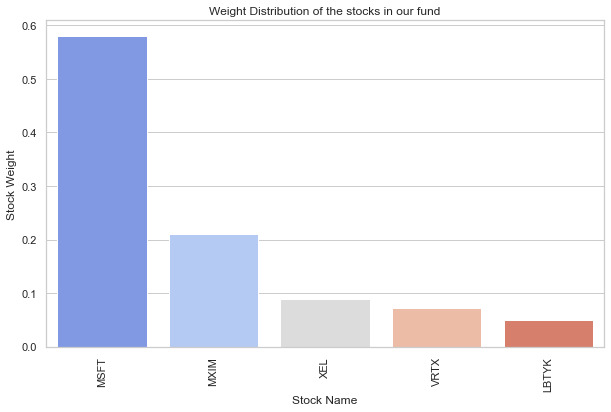

In [12]:
print('\n The difference between 2019 NASDAQ Index return and our fund return = ', round(portfolio.objval,2),'\n \n', 'The weights assignd to stocks in our funds are -')

portfolio_weights_df = pd.DataFrame()
portfolio_weights_df['stock'] = selected_columns_list
portfolio_weights_df['weights'] = portfolio_weights.x.tolist()

portfolio_weights_df = portfolio_weights_df.sort_values('weights', ascending = False)
display(portfolio_weights_df)

#Plotting the stocks and respective weights
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.set(style="whitegrid")
sns.barplot(x="stock", y="weights", data=portfolio_weights_df, palette="coolwarm")

# Set plot labels and title
plt.xlabel('Stock Name')
plt.ylabel('Stock Weight')
plt.title('Weight Distribution of the stocks in our fund')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.show()

**The weights assigned to our stocks in the fund are in line with how well they represent the index!**   

MSFT and MXIM were the most representative stocks, and they have also been assigned the highest weights.

Text(0.5, 1.0, '2019 - Fund Returns vs Index Returns')

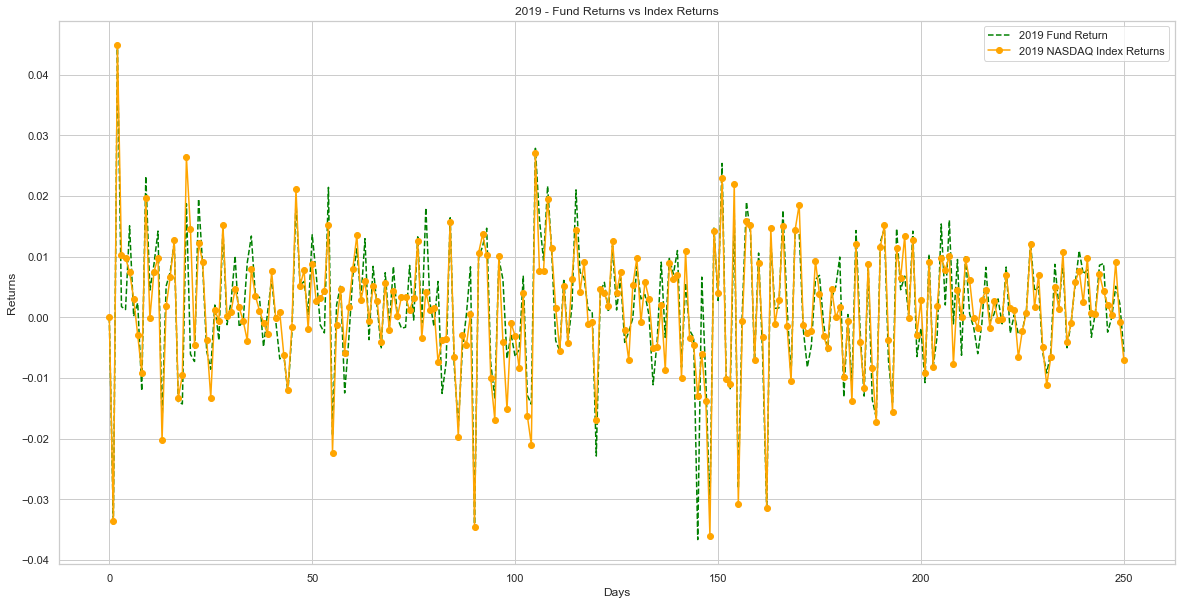

In [13]:
#lets plot the fund return vs NASDAQ index return for 2019
fil_2019_returns = returns_2019[selected_columns_list]
weight_x = portfolio_weights_df['weights']
weighted_fil_2019_return = pd.DataFrame()
for i,col in enumerate(fil_2019_returns.columns):
    weighted_fil_2019_return[col] = fil_2019_returns[col]*weight_x[i]
weighted_fil_2019_return['total_returns_fund'] = weighted_fil_2019_return[selected_columns_list].sum(axis=1)

plt.figure(figsize=(20, 10))

plt.plot(weighted_fil_2019_return['total_returns_fund'], label='2019 Fund Return',  color='green', linestyle='--')
plt.plot(index_2019, label='2019 NASDAQ Index Returns', marker='o',  color='orange')
# Add a legend
plt.legend()

# Add labels and title
plt.xlabel('Days')
plt.ylabel('Returns')
plt.title('2019 - Fund Returns vs Index Returns')

##### Now Lets find out how well our fund tracks the 2020 returns



The difference between the 2019 NASDAQ Index and the fund we have created (Training error) =  0.79 

The difference between the 2020 NASDAQ Index and the fund we have created (Testing error) =  1.11


Text(0.5, 1.0, '2020 - Fund Returns vs Index Returns')

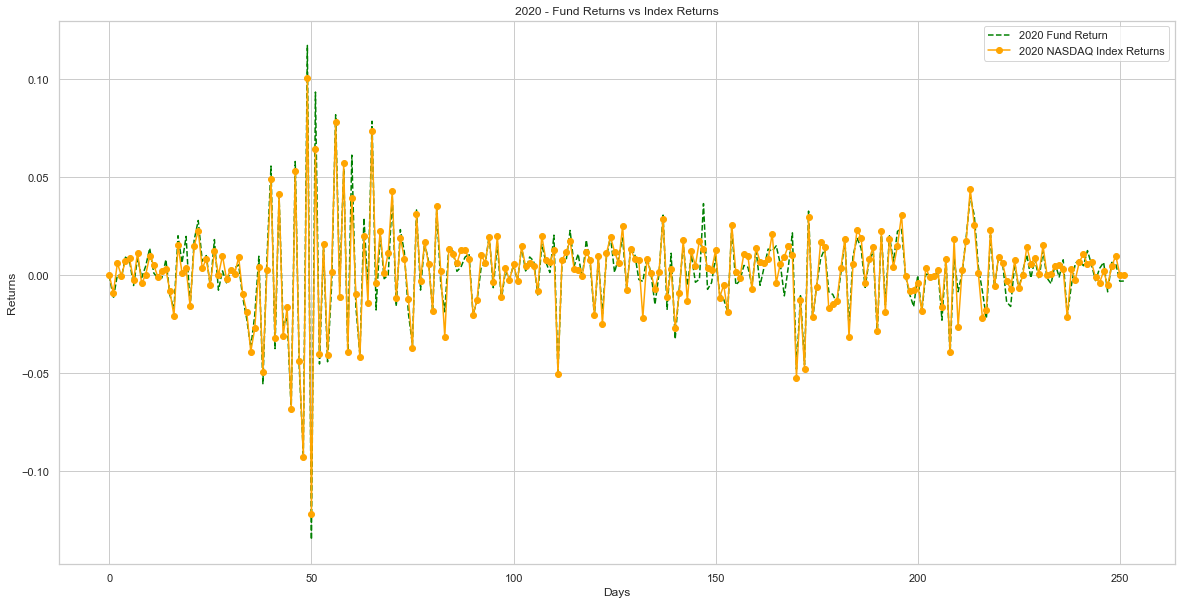

In [14]:
returns_2020 = stocks_2020.copy()  # Create a copy of the original DataFrame
returns_2020.drop(columns=['Unnamed: 0'], inplace=True)  # Drop the 'Date' column if it exists
returns_2020 = returns_2020.pct_change()
returns_2020 = returns_2020.fillna(0)
index_2020 = returns_2020['NDX']


#Now lets filter the 2020 return dataset for the selected stocks
fil_2020_returns = returns_2020[selected_columns_list]
weight_x = portfolio_weights_df['weights']
weighted_fil_2020_return = pd.DataFrame()
for i,col in enumerate(fil_2020_returns.columns):
    weighted_fil_2020_return[col] = fil_2020_returns[col]*weight_x[i]
weighted_fil_2020_return['total_returns_fund'] = weighted_fil_2020_return[selected_columns_list].sum(axis=1)
m_5_2020_error = sum(abs(returns_2020['NDX'] - weighted_fil_2020_return['total_returns_fund']))

print('\nThe difference between the 2019 NASDAQ Index and the fund we have created (Training error) = ', round(portfolio.objval,2),'\n')

print('The difference between the 2020 NASDAQ Index and the fund we have created (Testing error) = ' , round(m_5_2020_error,2))


plt.figure(figsize=(20, 10))

plt.plot(weighted_fil_2020_return['total_returns_fund'], label='2020 Fund Return',  color='green', linestyle='--')
plt.plot(index_2020, label='2020 NASDAQ Index Returns', marker='o',  color='orange')
# Add a legend
plt.legend()

# Add labels and title
plt.xlabel('Days')
plt.ylabel('Returns')
plt.title('2020 - Fund Returns vs Index Returns')

### Lets iterate through various different values of m

In [15]:
m_array = [5,10,20,30,40,50,60,70,80,90,100]

In [16]:
selected_stock_dictionary = {}
weights_dictionary = {}
objective_selected_stock = []
for m in m_array:
    
    if n>=m:
    
        fund_creator = gp.Model() 
        selected_stocks = fund_creator.addMVar(n, vtype = 'B') #Binary variable to flag the selected stocks
        linking_stocks = fund_creator.addMVar((n,n), vtype = 'B') #Binary variable to link stock in index to the fund

        selection_const = fund_creator.addConstr(gp.quicksum(selected_stocks[i] for i in range(n)) <= m)
        one_representative_const = fund_creator.addConstrs(gp.quicksum(linking_stocks[i,j] for j in range(n)) ==1 for i in range(n))
        ensure_best_representative_const = fund_creator.addConstrs(linking_stocks[i,j] <= selected_stocks[j] for j in range(n) for i in range(n))

        # Set the objective function using the calculated values
        fund_creator.setObjective(gp.quicksum(correl_2019.iloc[i, j] * linking_stocks[i,j] for i in range(n) for j in range(n) ), sense=gp.GRB.MAXIMIZE)
        fund_creator.Params.OutputFlag = 0
        fund_creator.optimize()
        
        objective_selected_stock.append(fund_creator.objval)
        
        # Convert the array to a pandas Series for easier manipulation
        selection_series = pd.Series(selected_stocks.x)
        # Get the selected columns from returns_2019
        selected_columns = correl_2019.columns[selection_series == 1]
        selected_columns_list = selected_columns.tolist()
#         print('\n M = ', m, ' | Selected Stocks = ', selected_columns_list, ' \n')
        selected_stock_dictionary[m] = selected_columns_list
        selected_stocks = returns_2019[selected_columns_list]
        index_2019 = returns_2019['NDX']

        portfolio = gp.Model()
        portfolio_weights = portfolio.addMVar(m)
        index_diff = portfolio.addMVar(days_2019)
        portfolio_weights_const = portfolio.addConstr(gp.quicksum(portfolio_weights[i] for i in range(m)) == 1)

        mod_const_1 = portfolio.addConstrs(
            (gp.quicksum(portfolio_weights[i] * selected_stocks.iloc[j, i] for i in range(m)) - index_2019[j]) <= index_diff[j]
            for j in range(days_2019)
        )
        mod_const_2 = portfolio.addConstrs(
            (-1 * gp.quicksum(portfolio_weights[i] * selected_stocks.iloc[j, i] for i in range(m)) + index_2019[j]) <= index_diff[j]
            for j in range(days_2019)
        )
        portfolio.setObjective(gp.quicksum(index_diff[i] for i in range(days_2019)), sense = gp.GRB.MINIMIZE)
        portfolio.Params.OutputFlag = 0
        portfolio.optimize()
#         print('\n Portfolio Weights = ', portfolio_weights.x, ' \n')
        weights_dictionary[m] = portfolio_weights.x
    
    else:
        print('Error! Trying to select more stocks than present in the raw data!')

    

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


#### Let's find out how the error changes as we increase the value of m

In [17]:
#Below code calculates the training error - 2019 NASDAQ Index vs Fund

first_approach_errors_2019 = []

for m in m_array:
    if n>=m:
        #Now lets filter the 2020 return dataset for the selected stocks
        fil_2019_returns = returns_2019[selected_stock_dictionary[m]]
        weight_x = weights_dictionary[m].tolist()
        weighted_fil_2019_return = pd.DataFrame()
        for i,col in enumerate(fil_2019_returns.columns):
            weighted_fil_2019_return[col] = fil_2019_returns[col]*weight_x[i]
        weighted_fil_2019_return['total_returns_fund'] = weighted_fil_2019_return[selected_stock_dictionary[m]].sum(axis=1)
        first_approach_errors_2019.append(sum(abs(returns_2019['NDX'] - weighted_fil_2019_return['total_returns_fund'])))

#Below code calculates the training error - 2020 NASDAQ Index vs Fund

first_approach_errors_2020 = []

for m in m_array:
    if n>=m:
        #Now lets filter the 2020 return dataset for the selected stocks
        fil_2020_returns = returns_2020[selected_stock_dictionary[m]]
        weight_x = weights_dictionary[m].tolist()
        weighted_fil_2020_return = pd.DataFrame()
        for i,col in enumerate(fil_2020_returns.columns):
            weighted_fil_2020_return[col] = fil_2020_returns[col]*weight_x[i]
        weighted_fil_2020_return['total_returns_fund'] = weighted_fil_2020_return[selected_stock_dictionary[m]].sum(axis=1)
        first_approach_errors_2020.append(sum(abs(returns_2020['NDX'] - weighted_fil_2020_return['total_returns_fund'])))

In [18]:
first_approach_error_df = pd.DataFrame()
m_array_upd = []
for i in range(len(m_array)):
    if n>=m_array[i]:
        m_array_upd.append(m_array[i])
    
first_approach_error_df['selected_stocks'] = m_array_upd
first_approach_error_df['stock_selection_objective'] = objective_selected_stock
first_approach_error_df['2019_errors'] = first_approach_errors_2019
first_approach_error_df['2020_errors'] = first_approach_errors_2020


first_approach_error_df.set_index('selected_stocks', inplace = True)
first_approach_error_df

,stock_selection_objective,2019_errors,2020_errors
selected_stocks,,,
5,54.841179,0.789178,1.112437
10,59.333081,0.701218,1.102404
20,66.648971,0.466233,0.855213
30,72.697515,0.413754,0.769412
40,78.259750,0.369479,0.759083
50,83.316676,0.334688,0.783056
60,87.877830,0.334359,1.059970
70,92.062665,0.233021,0.857701
80,95.729016,0.148219,0.545540


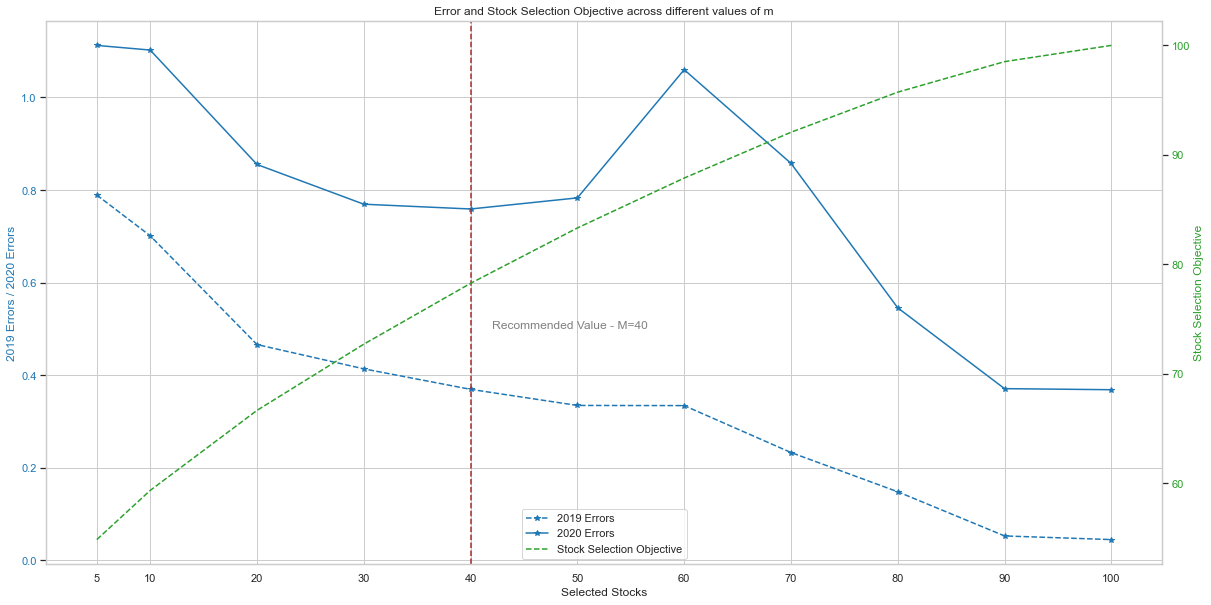

In [38]:
import matplotlib.pyplot as plt

# Create a figure and axis with increased figure size
fig, ax1 = plt.subplots(figsize=(20, 10))

# Plot the 2019 and 2020 errors on the primary y-axis with markers
ax1.set_xlabel('Selected Stocks')
ax1.set_ylabel('2019 Errors / 2020 Errors', color='tab:blue')
ax1.plot(first_approach_error_df['2019_errors'], label='2019 Errors', color='tab:blue', marker='*', linestyle='--')
ax1.plot(first_approach_error_df['2020_errors'], label='2020 Errors', color='tab:blue', marker='*')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a secondary y-axis for the selection objective as a dotted line
ax2 = ax1.twinx()

# Plot the stock selection objective on the secondary y-axis as a dotted line
ax2.set_ylabel('Stock Selection Objective', color='tab:green')
ax2.plot( first_approach_error_df['stock_selection_objective'], label='Stock Selection Objective', color='tab:green', linestyle='--')
ax2.tick_params(axis='y', labelcolor='tab:green')

# Add a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="lower center")

# Set the x-axis labels
plt.xticks(first_approach_error_df.index)

# # Add a dotted line at x=40 and label
# ax1.axvline(x=40, color='brown', linestyle='--', label='Recommended Value - M=40')
# ax1.annotate('Recommended Value - M=40', xy=(40, 0.5), xytext=(42, 0.5), color='gray', arrowprops=dict(arrowstyle='->'))


# Show the plot
plt.title('Error and Stock Selection Objective across different values of m')
plt.grid(False)
plt.show()


As the value of m increases, the training error keeps going down but the testing error reduces till m=40 and then it starts to increase. 
**M= 40 would be the ideal value**

### Q4 - The alternate approach (directly solving MIP)

#### Objective Function
$$\underset{w}{min} \sum_{t=1}^{T}\left | q_{t} - \sum_{i=1}^{n}w_{i}r_{it} \right |$$

#### Constraint 1 
$$\sum_{j=1}^{n} y_{j} = m$$

#### Constraint 2 - Wi = 0 if yi = 0
$$w_{i} \leq y_{i}$$

#### Constraint 3 - Sum of weights = 1 
$$ \sum_{i=1}^{m}w_{i} = 1$$

In [20]:
returns_2019.head()

,NDX,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,ANSS,AAPL,AMAT,ASML,ADSK,ADP,BIDU,BIIB,BMRN,BKNG,AVGO,CDNS,CDW,CERN,CHTR,CHKP,CTAS,CSCO,CTXS,CTSH,CMCSA,CPRT,COST,CSX,DXCM,DOCU,DLTR,EBAY,EA,EXC,EXPE,FB,FAST,FISV,GILD,IDXX,ILMN,INCY,INTC,INTU,ISRG,JD,KLAC,KHC,LRCX,LBTYA,LBTYK,LULU,MAR,MXIM,MELI,MCHP,MU,MSFT,MRNA,MDLZ,MNST,NTES,NFLX,NVDA,NXPI,ORLY,PCAR,PAYX,PYPL,PEP,PDD,QCOM,REGN,ROST,SGEN,SIRI,SWKS,SPLK,SBUX,SNPS,TMUS,TTWO,TSLA,TXN,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.033602,-0.035509,-0.039498,-0.094530,0.022030,-0.085791,-0.027696,-0.028484,-0.025242,-0.015216,-0.060405,-0.037550,-0.099607,-0.057945,-0.055150,-0.055133,-0.030198,-0.046471,0.007581,-0.008945,-0.034024,-0.088951,-0.039325,-0.025767,-0.022556,-0.001701,-0.011111,-0.016001,-0.036368,-0.014382,-0.031542,0.007856,-0.016569,-0.021196,-0.015658,-0.025352,-0.048751,-0.004825,-0.018371,-0.020655,0.001135,-0.030898,-0.029039,-0.028399,-0.029082,0.028531,-0.024334,-0.034904,0.070799,-0.055013,-0.030596,-0.033882,-0.043253,-0.056099,-0.000692,-0.048229,0.001404,-0.006280,0.008188,-0.053229,-0.056845,-0.004765,-0.070498,-0.053435,-0.036788,0.011089,-0.003760,-0.015587,-0.038478,0.013226,-0.060417,-0.040783,0.014598,-0.023159,-0.016905,-0.042682,-0.009334,-0.031067,-0.029617,-0.000967,-0.008355,-0.019482,0.006780,-0.106533,-0.024293,-0.043377,-0.034979,-0.003678,-0.046726,-0.031472,-0.058973,-0.022834,-0.018591,-0.034989,-0.030557,-0.002133,-0.010435,-0.035808,-0.068217,-0.003940,-0.037651
2,0.044824,0.039903,0.048632,0.114370,0.057779,0.010445,0.051294,0.053786,0.050064,0.034184,0.024278,0.043737,0.042689,0.068484,0.043269,0.052770,0.039854,0.040333,0.036905,0.034442,0.032728,0.009828,0.041657,0.009724,0.030178,0.053009,0.029311,0.047024,0.045045,0.018860,0.042553,0.033776,0.035615,0.029039,0.029682,0.035453,0.053309,0.023468,0.022952,0.072545,0.011333,0.042112,0.047138,0.041041,0.044359,0.045977,0.052859,0.064910,0.061857,0.061362,0.039677,0.047619,0.094349,0.063978,0.027246,0.048849,0.064516,0.068546,0.033693,0.059662,0.044004,0.063185,0.040561,0.054839,0.046509,0.094193,0.027680,0.037292,0.040064,0.097234,0.064068,0.048353,-0.012452,0.044409,0.034860,0.050920,0.020506,0.054368,0.016158,0.068453,0.027203,0.056236,0.038720,0.047925,0.071719,0.033155,0.034398,0.037988,0.025719,0.057697,0.045230,0.058976,0.047954,0.044744,0.044147,0.054785,0.033269,0.060577,0.042356,0.009786,0.046303
3,0.010211,0.028196,0.013573,0.082632,0.018302,0.017192,-0.001994,-0.002167,0.034353,0.013457,0.006288,0.025477,-0.002226,0.017804,0.022847,0.034612,-0.005410,0.010252,0.012785,0.035477,-0.003336,0.020366,0.003699,-0.003980,-0.005744,-0.004195,-0.004556,0.001681,0.006757,0.003995,-0.001570,-0.010611,0.005560,0.003685,-0.005415,0.117946,0.019315,0.054581,0.017259,0.037550,0.001793,0.012998,0.000725,0.007308,-0.002049,0.004542,-0.002881,0.017179,0.026844,0.004659,0.015255,0.014332,0.022003,0.014239,0.018881,0.008909,-0.047870,-0.042766,0.043174,0.001855,0.010388,0.043161,0.029271,0.039755,0.001275,-0.040684,0.006856,-0.001205,0.042394,0.059717,0.052941,0.007422,-0.006231,-0.001186,-0

In [21]:
m_array = [5,10,20,30,40,50,60,70,80,90,100] 
M=1 #The smallest value of Big M that can effectively constrain the model
stock_weight_dictionary_complex = {}
selected_stock_dictionary_complex = {}

for m in m_array:
    
    if n>=m:
        MIP_model = gp.Model()
        select_stock = MIP_model.addMVar(n, vtype='B')
        stock_weight = MIP_model.addMVar(n)
        index_difference = MIP_model.addMVar(days_2019)

        selection_const_complex = MIP_model.addConstr(gp.quicksum(select_stock[i] for i in range(n)) == m)

        portfolio_weights_const_complex = MIP_model.addConstr(gp.quicksum(stock_weight[i] for i in range(n)) == 1)

        mod_const_1_complex = MIP_model.addConstrs(
            (gp.quicksum(stock_weight[i] * returns_2019.iloc[j, i + 1] for i in range(n)) - index_2019[j]) <= index_difference[j]
            for j in range(days_2019)
        )

        mod_const_2 = MIP_model.addConstrs(
            (-1 * gp.quicksum(stock_weight[i] * returns_2019.iloc[j, i + 1] for i in range(n)) + index_2019[j]) <= index_difference[j]
            for j in range(days_2019)
        )

        big_m_const = MIP_model.addConstrs(stock_weight[i]<=select_stock[i]*M for i in range(n))

        MIP_model.setObjective(gp.quicksum(index_difference[i] for i in range(days_2019)), sense = gp.GRB.MINIMIZE)
        MIP_model.setParam(gp.GRB.Param.TimeLimit, T)
        MIP_model.Params.OutputFlag = 0
        MIP_model.optimize()
        
        print('\n','Number of Stocks selected = ', m, ' | ', 'Objective Value = ',MIP_model.objval, '\n')
        selected_stock_dictionary_complex[m] = select_stock.x
        stock_weight_dictionary_complex[m] = stock_weight.x
    


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter TimeLimit to value 6

 Number of Stocks selected =  5  |  Objective Value =  0.648512771760824 

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter TimeLimit to value 6

 Number of Stocks selected =  10  |  Objective Value =  0.6154677039941919 

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter TimeLimit to value 6

 Number of Stocks selected =  20  |  Objective Value =  0.3204745302779432 

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter TimeLimit to value 6

 Number of Stocks selected =  30  |  Objective Value =  0.23703823559022358 

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter TimeLimit to value 6

 Number of Stocks selected =  40  |  Objective Value =  0.1753031830814633 

Warning for adding constraints: zero or small 

In [35]:

stock_weight_complex_df = pd.DataFrame(stock_weight_dictionary_complex)
stock_weight_complex_df.to_csv(r'C:\Users\rsk29\Documents\UT\Fall\Optimization\Project - 2\stock_weight_dictionary_complex_1.csv')

selected_stock_complex_df = pd.DataFrame(selected_stock_dictionary_complex)
selected_stock_complex_df.to_csv(r'C:\Users\rsk29\Documents\UT\Fall\Optimization\Project - 2\selected_stock_dictionary_complex_1.csv')

In [28]:
# #Reading the results from running the above MIP model for 10 hours
# stock_weight_complex_df = pd.read_csv(r'stock_weight_dictionary_complex.csv')
# selected_stock_complex_df = pd.read_csv(r'selected_stock_dictionary_complex.csv')

# stock_weight_complex_df.drop(columns = ['Unnamed: 0'], inplace = True)
# selected_stock_complex_df.drop(columns = ['Unnamed: 0'], inplace = True)

In [36]:
selected_stock_dictionary_names_complex = {}
returns_2020_x = returns_2020.drop(columns = ['NDX'])

for m in m_array:
    if n>=m:
# Convert the array to a pandas Series for easier manipulation
        selection_series = pd.Series(selected_stock_complex_df[m])
        # Get the selected columns from returns_2019
        selected_columns = returns_2020_x.columns[selection_series == 1]
        selected_columns_list = selected_columns.tolist()
        selected_stock_dictionary_names_complex[m] = selected_columns_list

returns_2019_x = returns_2019.drop(columns = ['NDX'])
returns_2020_x = returns_2020.drop(columns = ['NDX'])

complex_errors_2019 = []
complex_errors_2020 = []

for m in m_array:
     if n>=m:
        weight_x = stock_weight_complex_df[m]
        weighted_fil_2019_return = pd.DataFrame()
        for i,col in enumerate(returns_2019_x.columns):
            weighted_fil_2019_return[col] = returns_2019_x[col]*weight_x[i]

        weighted_fil_2019_return['total_returns_fund'] = weighted_fil_2019_return[selected_stock_dictionary_names_complex[m]].sum(axis=1)
        complex_errors_2019.append(sum(abs(index_2019 - weighted_fil_2019_return['total_returns_fund'])))

for m in m_array:
     if n>=m:
        weight_x = stock_weight_complex_df[m]
        weighted_fil_2020_return = pd.DataFrame()
        for i,col in enumerate(returns_2020_x.columns):
            weighted_fil_2020_return[col] = returns_2020_x[col]*weight_x[i]

        weighted_fil_2020_return['total_returns_fund'] = weighted_fil_2020_return[selected_stock_dictionary_names_complex[m]].sum(axis=1)
        complex_errors_2020.append(sum(abs(returns_2020['NDX'] - weighted_fil_2020_return['total_returns_fund'])))

complex_errors_df = pd.DataFrame()
complex_errors_df['2019_errors_complex'] = complex_errors_2019
complex_errors_df['2020_errors_complex'] = complex_errors_2020

Text(0.5, 1.0, '2019 and 2020 Errors for different values of m (stocks selected)')

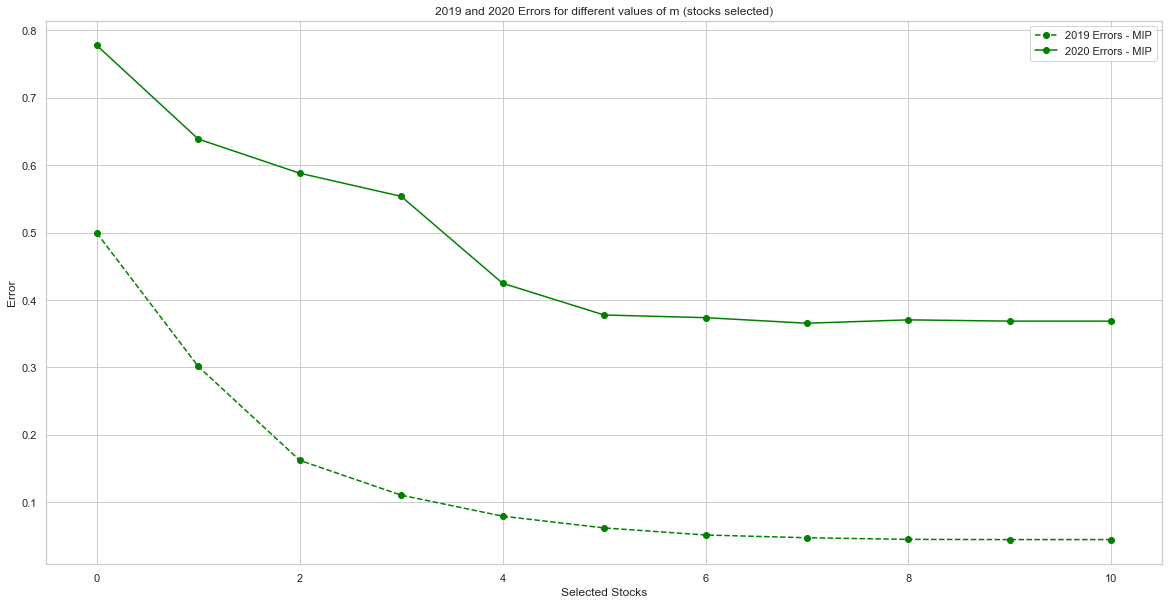

In [32]:
plt.figure(figsize=(20, 10))

plt.plot(complex_errors_df['2019_errors_complex'], label='2019 Errors - MIP', marker='o',  color='green', linestyle='--')
plt.plot(complex_errors_df['2020_errors_complex'], label='2020 Errors - MIP', marker='o',  color='green')
# Add a legend
plt.legend()

# Add labels and title
plt.xlabel('Selected Stocks')
plt.ylabel('Error')
plt.title('2019 and 2020 Errors for different values of m (stocks selected)')

#### Comparing the results from our first approach ( based on correlation ) and second approach ( minimizing index returns difference) for stock selection

In [33]:
combined_df = first_approach_error_df.reset_index()
combined_df['2019_errors_MIP'] = complex_errors_df['2019_errors_complex']
combined_df['2020_errors_MIP'] = complex_errors_df['2020_errors_complex']
combined_df.set_index('selected_stocks', inplace = True)
combined_df

,stock_selection_objective,2019_errors,2020_errors,2019_errors_MIP,2020_errors_MIP
selected_stocks,,,,,
5,54.841179,0.789178,1.112437,0.499259,0.777362
10,59.333081,0.701218,1.102404,0.301498,0.638550
20,66.648971,0.466233,0.855213,0.162433,0.587937
30,72.697515,0.413754,0.769412,0.110752,0.553649
40,78.259750,0.369479,0.759083,0.079619,0.424802
50,83.316676,0.334688,0.783056,0.062217,0.377808
60,87.877830,0.334359,1.059970,0.051720,0.373836
70,92.062665,0.233021,0.857701,0.047631,0.365585
80,95.729016,0.148219,0.545540,0.045227,0.370600


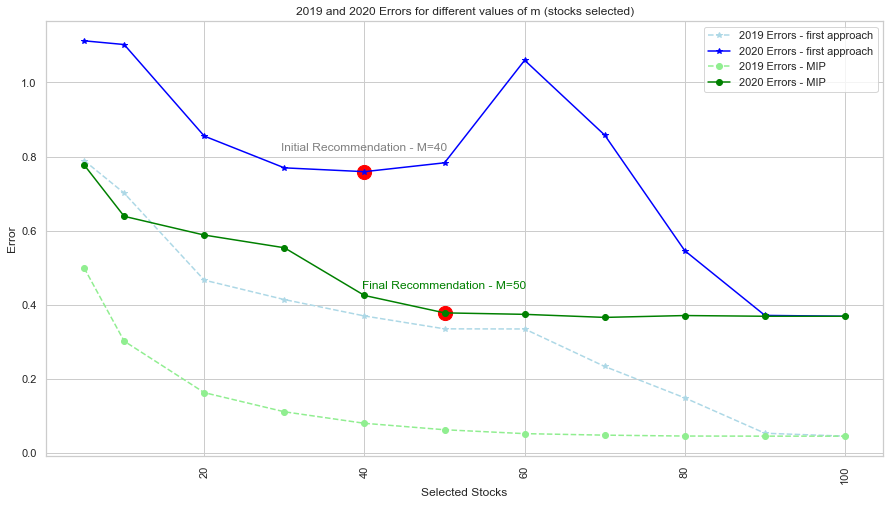

In [34]:
# Create a figure and set its size
plt.figure(figsize=(15, 8))

# Create a line chart for 2019 errors
plt.plot(combined_df['2019_errors'], label='2019 Errors - first approach', marker='*', color='lightblue', linestyle='--')
plt.plot(combined_df['2020_errors'], label='2020 Errors - first approach', marker='*', color='blue')

plt.plot(combined_df['2019_errors_MIP'], label='2019 Errors - MIP', marker='o', color='lightgreen', linestyle='--')
plt.plot(combined_df['2020_errors_MIP'], label='2020 Errors - MIP', marker='o', color='green')

# Add labels and title
plt.xlabel('Selected Stocks')
plt.ylabel('Error')
plt.title('2019 and 2020 Errors for different values of m (stocks selected)')

# Add a legend
plt.legend()

# Circle the points for recommendations
plt.scatter([40, 50], [combined_df.loc[40, '2020_errors'], combined_df.loc[50, '2020_errors_MIP']], marker='o', color='red', s=200, label='Recommendations')

# # Add text labels for recommendations
# plt.text(40, combined_df.loc[40, '2020_errors'] +0.05, 'Initial Recommendation - M=40', fontsize=12, color='gray', va='bottom', ha='center')
# plt.text(50, combined_df.loc[50, '2020_errors_MIP']+0.06, 'Final Recommendation - M=50', fontsize=12, color='green', va='bottom', ha='center')


# Show all x-axis values
plt.xticks(rotation=90)  # Rotate the x-axis labels by 90 degrees

plt.show()
